In [ ]:
# 911 Emergency Prediction - FIXED VERSION

# 1. Install libraries
!pip install pandas scikit-learn h3

# 2. Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from datetime import timedelta, datetime
import random


In [ ]:

# 3. Load your dataset
df = pd.read_csv('/content/911_cleaned (2).csv')
df.head

# 4. Fix: Check available columns
print(df.columns)


Index(['lat', 'lng', 'desc', 'zip', 'title', 'timeStamp', 'twp', 'addr', 'e',
       'hour', 'dayofweek', 'date', 'call_type', 'h3_cell', 'year', 'month',
       'description_of_emergency'],
      dtype='object')


In [ ]:

# Assuming your DataFrame is named df

# Mapping old column names to new column names
rename_mapping = {
    'addr': 'Address',
    'call_type': 'call_type',
    'date': 'date',
    'dayofweek': 'dayofweek',
    'desc': 'Description',
    'description_of_emergency': 'description of emergency',
    'h3_cell': 'h3_cell',
    'hour': 'Hour',
    'lat': 'Lat',
    'lng': 'Long',
    'month': 'Month',
    'timeStamp': 'timeStamp',
    'title': 'title',
    'twp': 'twp',
    'year': 'Year',
    'zip': 'Zip Code'
}

# Rename the columns
df = df.rename(columns=rename_mapping)

# If you want to check
print(df.columns)

Index(['Lat', 'Long', 'Description', 'Zip Code', 'title', 'timeStamp', 'twp',
       'Address', 'e', 'Hour', 'dayofweek', 'date', 'call_type', 'h3_cell',
       'Year', 'Month', 'description of emergency'],
      dtype='object')


In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['timeStamp'] = pd.to_datetime(df['timeStamp'], errors='coerce')

print("✅ Dates converted successfully!")


# 5. Keep relevant columns (renamed properly)
data = df[['Lat', 'Long', 'call_type', 'description of emergency', 'Hour', 'dayofweek']].copy()

# 6. Cluster accident locations using Lat/Long
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=42)
data['cluster'] = kmeans.fit_predict(data[['Lat', 'Long']])

# 7. Calculate call_type distribution
call_type_distribution = data['call_type'].value_counts(normalize=True)

# 8. Generate date range for March 2016
start_date = datetime(2020, 8, 1)
end_date = datetime(2020, 8, 31)
dates_march = pd.date_range(start_date, end_date)

# 9. Simulate future data
predicted_data = []
num_samples = 3000  # You can change this number

for _ in range(num_samples):
    date = random.choice(dates_march)
    cluster_id = random.choice(data['cluster'].unique())

    center_lat, center_lng = kmeans.cluster_centers_[cluster_id]

    # Add small noise to generate nearby location
    lat = center_lat + np.random.normal(0, 0.005)
    lng = center_lng + np.random.normal(0, 0.005)

    # Sample call type
    call_type = np.random.choice(call_type_distribution.index, p=call_type_distribution.values)

    # Sample Description from that call_type
    desc_options = df[df['call_type'] == call_type]['description of emergency']
    if not desc_options.empty:
        desc = random.choice(desc_options.tolist())
    else:
        desc = "General Emergency"

    predicted_data.append([date.strftime('%Y-%m-%d'), lat, lng, call_type, desc])

# 10. Create final DataFrame
output_df = pd.DataFrame(predicted_data, columns=['date', 'lat', 'lng', 'call_type', 'description of emergency'])

# 11. Save to CSV
output_df.to_csv('Aug_2020_predictions.csv', index=False)

print("✅ Output CSV 'Aug_2020_predictions.csv' created with predictions for aug!")


✅ Dates converted successfully!
✅ Output CSV 'Aug_2020_predictions.csv' created with predictions for aug!


In [ ]:
print(output_df.columns.tolist())

['date', 'lat', 'lng', 'call_type', 'description of emergency']


In [ ]:
import folium
import pandas as pd
from folium.plugins import MarkerCluster

# Load your output CSV
predicted_df = pd.read_csv("/content/Aug_2020_predictions.csv")

# Create a base map centered around the mean of your latitudes and longitudes
map_center = [predicted_df['lat'].mean(), predicted_df['lng'].mean()]
m = folium.Map(location=map_center, zoom_start=11)

# Add a cluster for better visualization
marker_cluster = MarkerCluster().add_to(m)

# Define emojis based on call_type
emoji_map = {
    'EMS': '🚑',      # Ambulance
    'Fire': '🔥',     # Fire
    'Traffic': '🚓',  # Police car
    'Other': '❓'      # Default emoji for unknown
}

# Add pins (markers) for each predicted hotspot
for idx, row in predicted_df.iterrows():
    emoji = emoji_map.get(row['call_type'], '❓')  # Get emoji or ❓ if not found
    popup_text = f"{emoji} <b>Call Type:</b> {row['call_type']}<br><b>Description:</b> {row['description of emergency']}<br><b>Date:</b> {row['date']}"

    folium.Marker(
        location=[row['lat'], row['lng']],
        popup=popup_text,
        icon=folium.DivIcon(
            html=f"""<div style="font-size:24px;">{emoji}</div>"""
        )
    ).add_to(marker_cluster)

# Save the map to an HTML file
m.save('predicted_hotspots_map_with_emoji.html')

print("✅ Map created with emoji markers! Check 'predicted_hotspots_map_with_emoji.html'.")


✅ Map created with emoji markers! Check 'predicted_hotspots_map_with_emoji.html'.


In [ ]:
print(df.columns.tolist())

['Lat', 'Long', 'Description', 'Zip Code', 'title', 'timeStamp', 'twp', 'Address', 'e', 'Hour', 'dayofweek', 'date', 'call_type', 'h3_cell', 'Year', 'Month', 'description of emergency']


EVALUATION METRICS

1. 1. 📊 Call Type Distribution Match


In [ ]:
# Historical call type distribution (Dec to Feb)
historical_dist = df['call_type'].value_counts(normalize=True)

# Simulated call type distribution (March)
simulated_dist = output_df['call_type'].value_counts(normalize=True)

# KL Divergence (lower is better)
from scipy.stats import entropy
kl_div = entropy(simulated_dist, historical_dist)
print(f"KL Divergence (call_type): {kl_div:.4f}")


KL Divergence (call_type): 0.0001


2. 📍 Geographic Clustering Validation


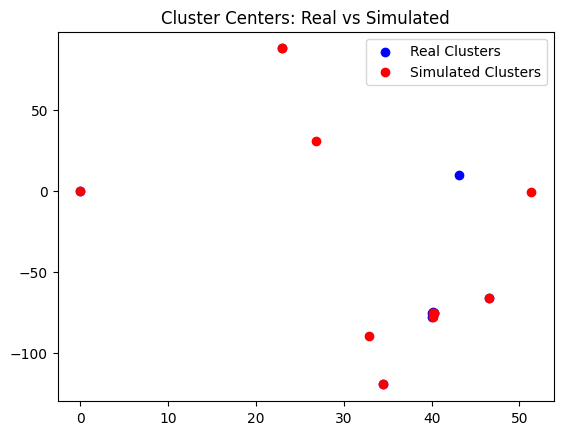

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Train KMeans on real data
kmeans_real = KMeans(n_clusters=10, random_state=42).fit(df[['Lat', 'Long']])
kmeans_pred = KMeans(n_clusters=10, random_state=42).fit(output_df[['lat', 'lng']])

# Plot cluster centers
plt.scatter(*zip(*kmeans_real.cluster_centers_), c='blue', label='Real Clusters')
plt.scatter(*zip(*kmeans_pred.cluster_centers_), c='red', label='Simulated Clusters')
plt.legend()
plt.title("Cluster Centers: Real vs Simulated")
plt.show()


3. 🗓️ Daily Call Volume Trend


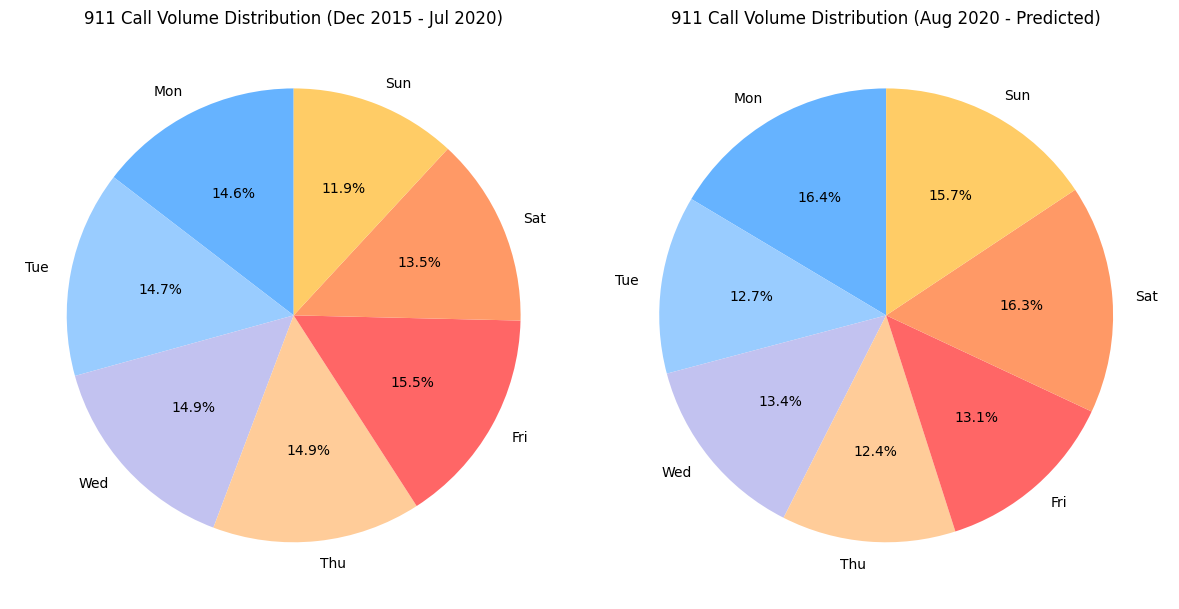

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load historical data (Dec 2015-Feb 2016) and predicted data (March 2016)
historical_data = pd.read_csv("/content/911_cleaned (2).csv")
predicted_data = pd.read_csv("/content/Aug_2020_predictions.csv")

# Convert 'date' columns to datetime type
historical_data['date'] = pd.to_datetime(historical_data['date'])
predicted_data['date'] = pd.to_datetime(predicted_data['date'])

# Add 'dayofweek' column to both datasets (0=Monday, 6=Sunday)
historical_data['dayofweek'] = historical_data['date'].dt.dayofweek
predicted_data['dayofweek'] = predicted_data['date'].dt.dayofweek

# Group by 'dayofweek' and count the number of calls for both datasets
historical_weekday_vol = historical_data.groupby('dayofweek').size()
predicted_weekday_vol = predicted_data.groupby('dayofweek').size()

# Plot Pie Chart for historical data (Dec 2015 - Feb 2016)
plt.figure(figsize=(12, 6))

# Create the first pie chart for historical data
plt.subplot(1, 2, 1)
plt.pie(historical_weekday_vol, labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#99ccff', '#c2c2f0', '#ffcc99', '#ff6666', '#ff9966', '#ffcc66'])
plt.title('911 Call Volume Distribution (Dec 2015 - Jul 2020)')

# Create the second pie chart for predicted data (March 2016)
plt.subplot(1, 2, 2)
plt.pie(predicted_weekday_vol, labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#99ccff', '#c2c2f0', '#ffcc99', '#ff6666', '#ff9966', '#ffcc66'])
plt.title('911 Call Volume Distribution (Aug 2020 - Predicted)')

# Display the pie charts
plt.tight_layout()
plt.show()
